In [2]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Loading libraries

In [3]:
# Import system libraries
import os
import time
import shutil
import itertools

# Import data handling tools  
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# Import Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax, SGD, AdamW
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

print('Modules loaded')



Modules loaded


### Defining Hyperparameters

In [4]:
# Data pre-processing
Batch_size = 32
IMAGE_SIZE = (224, 224)
Epochs = 90
Channels = 3  # Number of color channels (RGB)

In [5]:
# Use raw string for Windows path to avoid escape character issues
PATH = r"C:\Users\joest\OneDrive\Desktop\MINI-Project\lung-model\Data\The IQ-OTHNCCD lung cancer dataset"


In [6]:
# Ensure the PATH is correct
if not os.path.exists(PATH):
    print(f"The path {PATH} does not exist. Please check the path.")
else:
    # Read the dataset using directory
    directory = tf.keras.utils.image_dataset_from_directory(
        PATH,
        seed=42,
        shuffle=True,
        image_size=IMAGE_SIZE,
        batch_size=Batch_size
    )
    print(f"Dataset loaded successfully: {type(directory)}")


Found 2073 files belonging to 3 classes.
Dataset loaded successfully: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


## Exploratory Data Analysis

In [7]:
# get class names associated with dataset images
categories = directory.class_names
print(repr(categories)) # repr() helps to get string representation of the list

['Bengin cases', 'Malignant cases', 'Normal cases']


In [8]:
# initialze an empty dictionary to carry the size of each image
size_data = {}
for i in categories:
    path = os.path.join(PATH, i)
    class_num = categories.index(i)
    temp_dict = {}

    # iterate over the images in the dataset
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath)
        Original_image_Size = np.shape(img)
        if len(Original_image_Size) > 2:

            # get height, width and channels for each image
            height, width, channels = cv2.imread(filepath).shape
            if str(height) + ' x ' + str(width) in temp_dict:
                temp_dict[str(height) + ' x ' + str(width)] += 1
            else:
                temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

# size_data

In [9]:
size_data.keys()

dict_keys(['Bengin cases', 'Malignant cases', 'Normal cases'])

In [10]:
# Flatten the nested dictionary into a single dictionary
flattened_data = {}
for key, value in size_data.items():
    count = 0
    for sub_key, sub_value in value.items():
        count += sub_value
    flattened_data[key] = count
flattened_data

{'Bengin cases': 120, 'Malignant cases': 1339, 'Normal cases': 614}

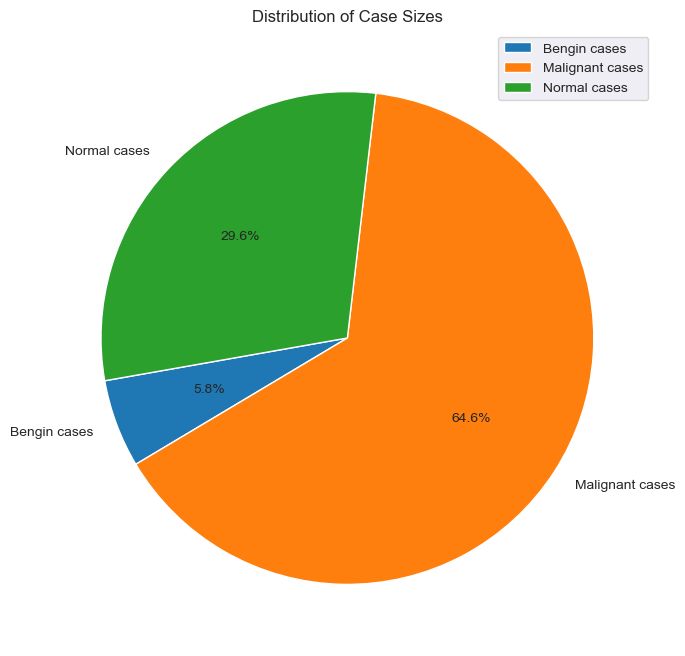

In [11]:
# Get the labels and counts from the flattened_data dictionary
labels = list(flattened_data.keys())
counts = list(flattened_data.values())

# Set the figure size
plt.figure(figsize=(8, 8))

# Create the pie chart using Matplotlib
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=190)

# Add count values to the pie chart
alignments = ['top', 'bottom', 'center']
for i, count in enumerate(counts):
    plt.text(
        x=0.5,
        y= i*0.3,
        s='',
        horizontalalignment = 'left',
        verticalalignment = alignments[i],
        fontsize = 15,
        fontweight = 'bold',
        color='black',
    )

# Add a title
plt.title('Distribution of Case Sizes')
plt.legend()

# Show the plot
plt.show()


In [12]:
# print the shape of sample image batch and convert it to numpy array
for image_batch, label_batch in directory.take(1):
    print(image_batch.shape)
    print(image_batch[1])
    print(label_batch.numpy())

(32, 224, 224, 3)
tf.Tensor(
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.61415786 0.61415786 0.61415786]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.   

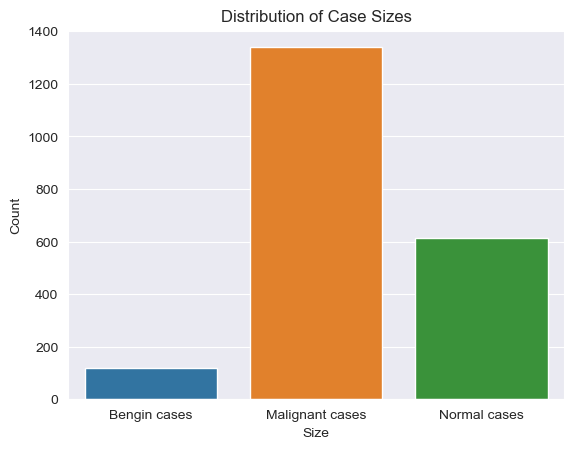

In [13]:
# Convert the flattened_data dictionary to a DataFrame
data_df = pd.DataFrame.from_dict(flattened_data, orient='index', columns=['Count'])
data_df.reset_index(inplace=True)
data_df.rename(columns={'index': 'Size'}, inplace=True)

# Create a bar plot using Seaborn
sns.barplot(data=data_df, x='Size', y='Count')
plt.title('Distribution of Case Sizes')
plt.xlabel('Size')
plt.ylabel('Count')
plt.show()

## DataSet images Visualizaton
#### Display some random images

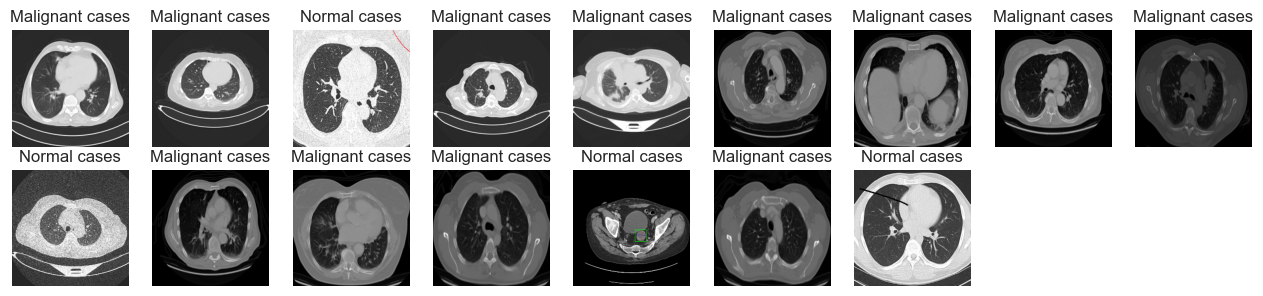

In [14]:
# define the figure size
plt.figure(figsize=(16, 16))
# iterate over the images in the shuffled dataset and take a sample consists of 16 images with their corresponding labels
for image_batch, labels_batch in directory.take(1):
    for i in range(16):
        ax = plt.subplot(9, 9, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(categories[labels_batch[i]])
        plt.axis("off")

#### Display a sample image in each class

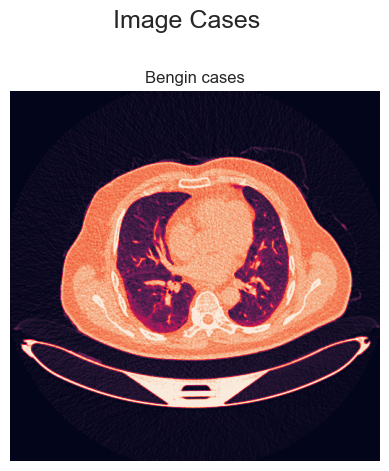

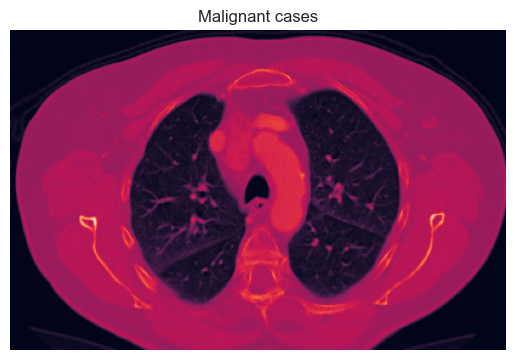

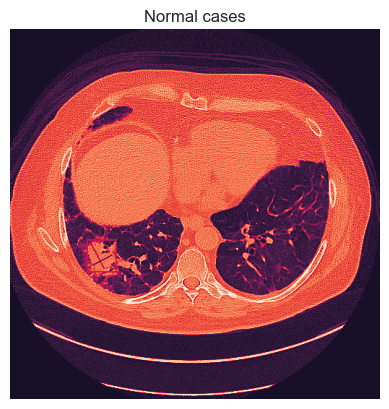

In [15]:
# show a sample from each class of images
plt.suptitle('Image Cases', y=1.05, fontsize=18)
for i in categories:
    path = os.path.join(PATH, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.axis("off")
        plt.title(i)
        plt.show()
        break

# Data Pre-Processing

In [16]:
# Resize and Rescale the Data
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(*IMAGE_SIZE),  # No need for 'experimental'
    tf.keras.layers.Rescaling(1./255),
])


# Creating Helper Functions

In [17]:
import os
import pandas as pd

# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    classes = os.listdir(dir)
    for class_name in classes:
        if os.path.isdir(os.path.join(dir, class_name)):
            class_path = os.path.join(dir, class_name)
            filelist = os.listdir(class_path)
            for file in filelist:
                fpath = os.path.join(class_path, file)
                filepaths.append(fpath)
                labels.append(class_name)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)


# Split data into train, validation, and test
def split_data(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df, test_df = train_valid_test_split(df, train_size=0.8, valid_size=0.05, test_size=0.15, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df


# Custom train, validation, test split function
def train_valid_test_split(df, train_size, valid_size, test_size, shuffle=True, random_state=None, stratify=None):
    assert train_size + valid_size + test_size == 1.0, "The sum of train_size, valid_size, and test_size should be 1.0"

    if shuffle:
        df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    num_samples = len(df)
    train_end = int(train_size * num_samples)
    valid_end = int((train_size + valid_size) * num_samples)

    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]

    return train_df, valid_df, test_df


# Get Dataframes
data_dir = PATH
train_df, valid_df, test_df = split_data(data_dir)

# Display the head of each dataframe
print("Train Data:")
print(train_df.head())
print("")
print(train_df.tail())
print("")

print("Validation Data:")
print(valid_df.head())
print("")
print(valid_df.tail())
print("")

print("Test Data:")
print(test_df.head())
print("")
print(test_df.tail())

Train Data:
                                           filepaths           labels
0  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...     Normal cases
1  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...  Malignant cases
2  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...  Malignant cases
3  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...  Malignant cases
4  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...  Malignant cases

                                              filepaths           labels
1653  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...     Normal cases
1654  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...  Malignant cases
1655  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...  Malignant cases
1656  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...     Normal cases
1657  C:\Users\joest\OneDrive\Desktop\MINI-Project\l...  Malignant cases

Validation Data:
                                              filepaths           labels
1658  C:\Users\joest\OneDrive\Desktop\

## Dataset Partitioning

## Dataset Partitioning

In [18]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes
         data from image data generator.
         Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                            color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                            color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                           color_mode= color, shuffle= False, batch_size= test_batch_size)


    return train_gen, valid_gen, test_gen

train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, Batch_size)


Found 1658 validated image filenames belonging to 3 classes.
Found 104 validated image filenames belonging to 3 classes.
Found 311 validated image filenames belonging to 3 classes.


# Function to dispplay data sample

In [19]:
def show_images(gen):

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator


    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)

        # note
        index = np.argmax(labels[i])  # get image index

        class_name = classes[index]   # get class of image

        plt.title(class_name, color= 'blue', fontsize= 8)
        plt.axis('off')
    plt.show()

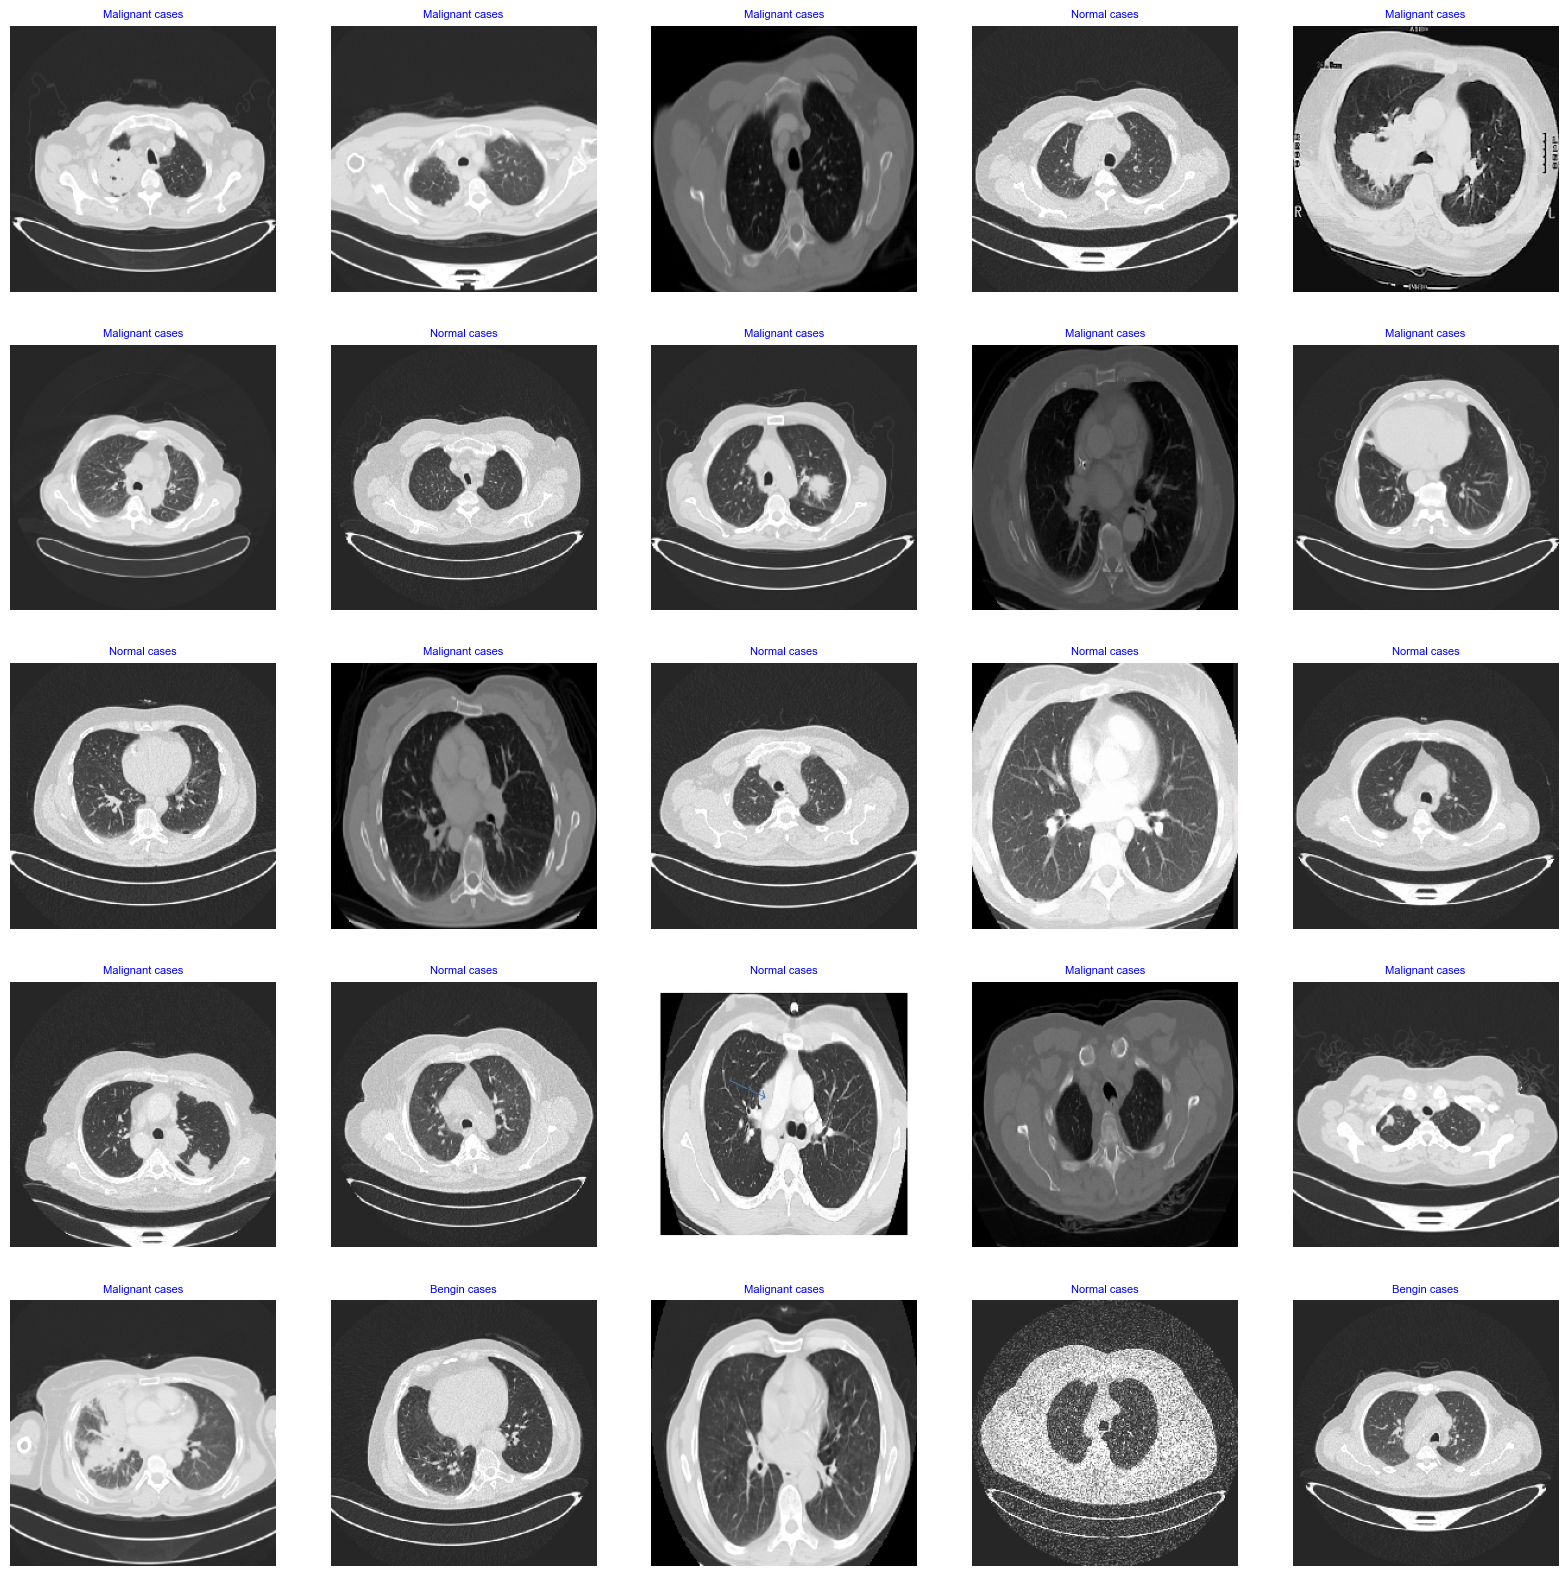

In [20]:
# Display Image Samples
show_images(train_gen)

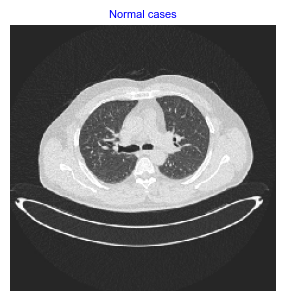

In [21]:
show_images(test_gen)

# Introducing Class Weights to handle unbalanced data

In [22]:
class_counts = list(flattened_data.values())
# class_counts = train_df['labels'].value_counts()
total_samples = sum(class_counts)
class_weights = {i: total_samples / (3 * class_counts[i]) for i in range(len(class_counts))}

print('class_counts in train_df: ',class_counts)
print('class_weights: ',class_weights)

class_counts in train_df:  [120, 1339, 614]
class_weights:  {0: 5.758333333333334, 1: 0.5160567587752054, 2: 1.1254071661237786}


# Model Definition
## VGG-19 + ResNet101

In [23]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [24]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.layers import Concatenate, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L1L2
import tensorflow as tf

# Clear any previous session
tf.keras.backend.clear_session()

# Load the VGG19 model without the top (classification) layers
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')
resnet101_base = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

# Freeze the pre-trained layers of both models
vgg19_base.trainable = False
resnet101_base.trainable = False

# Inputs for the two models
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

# Obtain the output tensors of both models
vgg19_output = vgg19_base(input_tensor)
resnet101_output = resnet101_base(input_tensor)

# Concatenate the outputs
concatenated = Concatenate()([vgg19_output, resnet101_output])

# Additional layers
x = Dense(64, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001))(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

output = Dense(3, activation='softmax')(x)  # Assuming this is a multi-class problem

# Create the final model
final_model = Model(inputs=input_tensor, outputs=output)

# Print summary of the model
final_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg19 (Functional)            │ (None, 512)               │      20,024,384 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet101 (Functional)        │ (None, 2048)              │      42,658,176 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 2560)              │               0 │ vgg19[0][0],               │
│                               │                           │                 │ resnet101[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │         163,904 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64)                │             256 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 3)                 │             195 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 62,846,915 (239.74 MB)

 Trainable params: 164,227 (641.51 KB)

 Non-trainable params: 62,682,688 (239.12 MB)

In [25]:
import warnings
from tensorflow.keras.metrics import Precision, Recall, AUC  # Import the metrics

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [26]:
# Compile the model
final_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

In [27]:
# Print the model summary
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg19 (Functional)            │ (None, 512)               │      20,024,384 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet101 (Functional)        │ (None, 2048)              │      42,658,176 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 2560)              │               0 │ vgg19[0][0],               │
│                               │                           │                 │ resnet101[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │         163,904 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64)                │             256 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 3)                 │             195 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 62,846,915 (239.74 MB)

 Trainable params: 164,227 (641.51 KB)

 Non-trainable params: 62,682,688 (239.12 MB)

# Visualize The ANN Architecture
(Layers: Input - Hidden - Output)

In [28]:
!pip install pydot --upgrade
!pip install graphviz

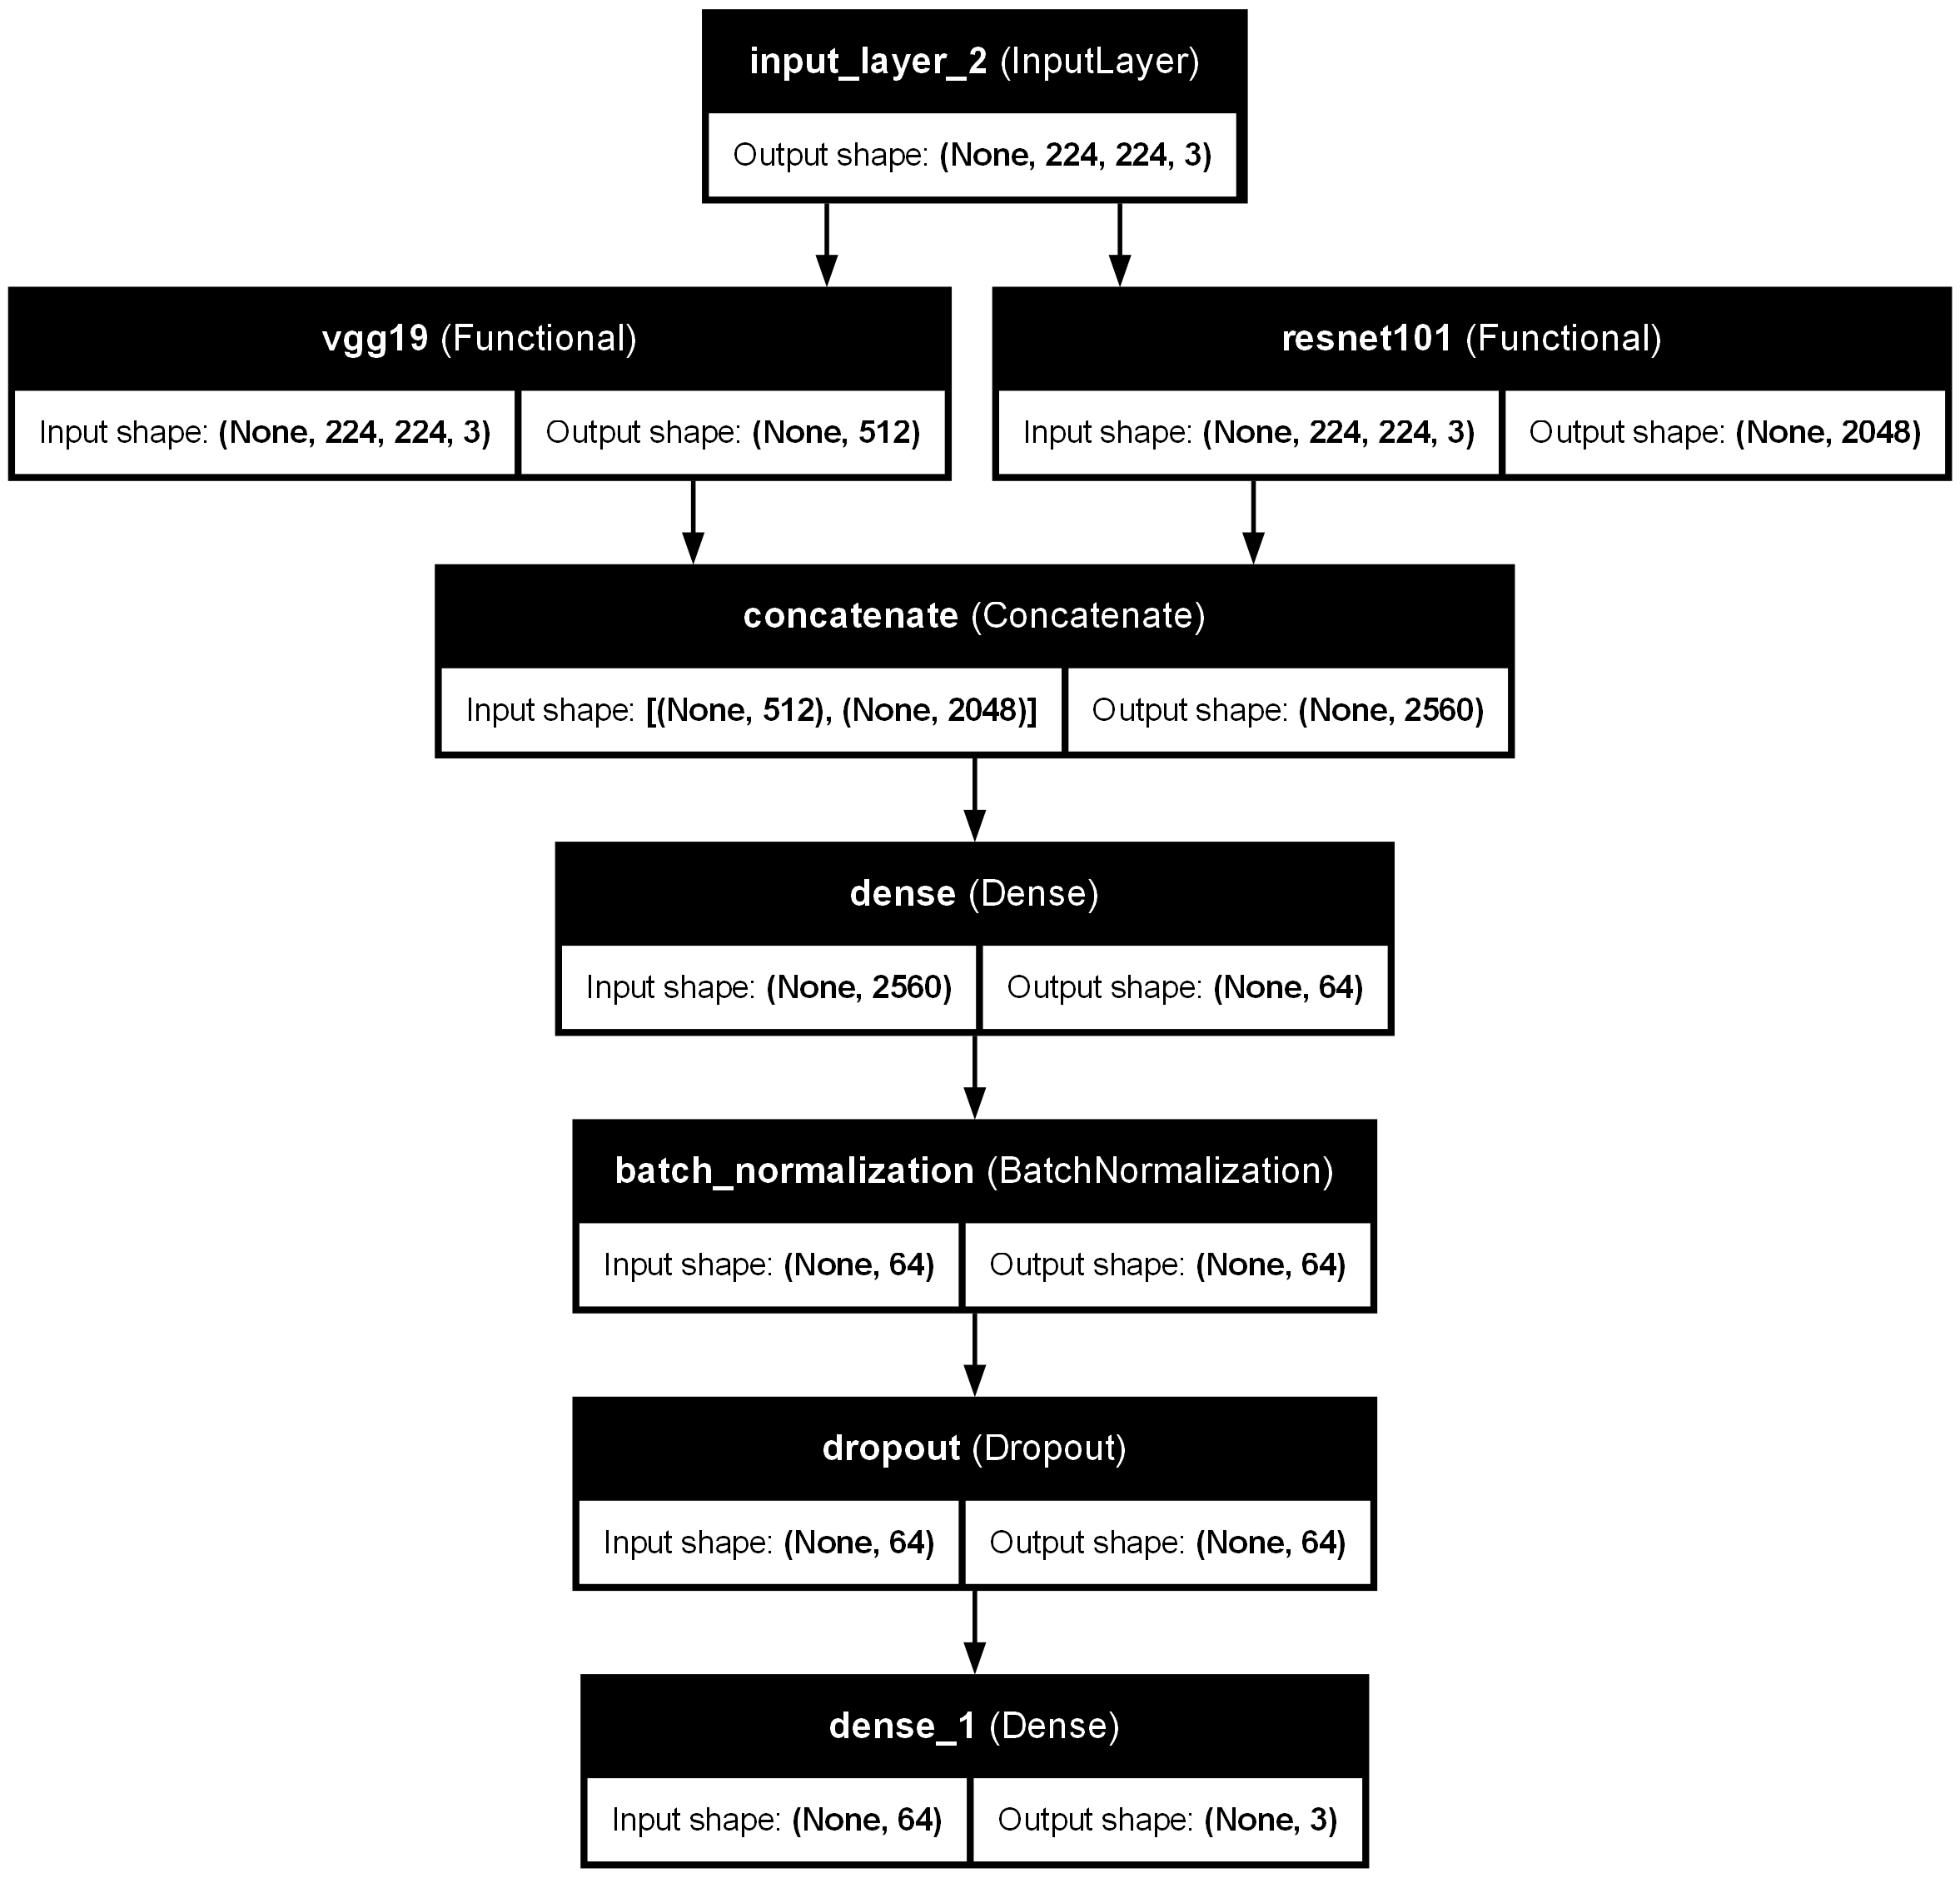

In [29]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Visualize the model architecture
plot_model(final_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the saved model architecture image
Image(filename='model_architecture.png')


# Define the callbacks

In [30]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.ask_permission = None

        # callback variables
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = None
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = None

    # Define a function that will run when training begins
    def on_train_begin(self, logs=None):
        # Accessing model attributes
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))  # fixed line
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

        msg = 'Do you want the model to ask you to halt the training [y/n]?'
        print(msg)
        ans = input('')
        if ans.lower() == 'y':
            self.ask_permission = 1
        elif ans.lower() == 'n':
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
        )
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
        print(msg)

        # Restore the best weights if necessary
        self.model.set_weights(self.best_weights)


# Set Callback Parameters

In [31]:
# Define the variables that are needed for the callback
patience = 3  # How many epochs to wait before adjusting the learning rate
stop_patience = 5  # How many epochs to wait before stopping the training
threshold = 0.9  # Threshold for accuracy to monitor (0.9 for 90% accuracy)
factor = 0.1  # Factor to reduce learning rate (e.g., reduce by 10%)
epochs = 20  # Total number of epochs to train
ask_epoch = 10  # Ask after every 10 epochs if training should stop
batch_size = 32  # Batch size for training

# Example of how to calculate batches (you need a dataset to calculate this)
batches = len(train_gen)  # Assuming train_gen is your training data generator

# Now you can initialize the callback without manually setting the model
callbacks = [MyCallback(
    patience=patience,
    stop_patience=stop_patience,
    threshold=threshold,
    factor=factor,
    batches=batches,
    epochs=epochs,
    ask_epoch=ask_epoch
)]


# Training

In [32]:
history = final_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,  # Set to 1 to monitor progress
    callbacks=callbacks,  # Ensure your callbacks don't ask for interaction
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True,
    class_weight=class_weights  # Ensure class weights are correctly defined
)

Do you want the model to ask you to halt the training [y/n]?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 442s 8s/step - accuracy: 0.3917 - auc: 0.5803 - loss: 5.3850 - precision: 0.3940 - recall: 0.3297 - val_accuracy: 0.3269 - val_auc: 0.5289 - val_loss: 6.2060 - val_precision: 0.3407 - val_recall: 0.2981
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 419s 8s/step - accuracy: 0.5775 - auc: 0.7718 - loss: 4.9223 - precision: 0.5946 - recall: 0.5232 - val_accuracy: 0.5865 - val_auc: 0.7530 - val_loss: 5.1649 - val_precision: 0.6146 - val_recall: 0.5673
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 420s 8s/step - accuracy: 0.6743 - auc: 0.8425 - loss: 4.7705 - precision: 0.7036 - recall: 0.6405 - val_accuracy: 0.7596 - val_auc: 0.8745 - val_loss: 4.7234 - val_precision: 0.7708 - val_recall: 0.7115
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 448s 9s/step - accuracy: 0.7111 - auc: 0.8755 - loss: 4.6901 - precision: 0.7368 - recall: 0.6746 - val_accuracy: 0.7404 - val_auc: 0.8906 - val_lo

In [36]:
# display of best validation loss and accuracy values

In [37]:
# Assuming `history` is the object returned by model.fit()
val_loss_per_epoch = history.history['val_loss']
val_accuracy_per_epoch = history.history['val_accuracy']

# Get the epoch with the minimum validation loss
best_epoch_loss = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

# Get the accuracy corresponding to the epoch with the best validation loss
best_epoch_accuracy = val_accuracy_per_epoch[best_epoch_loss - 1]

print(f'Best epoch based on validation loss = {best_epoch_loss}')
print(f'Validation loss at best epoch = {min(val_loss_per_epoch)}')
print(f'Validation accuracy at best epoch = {best_epoch_accuracy:.4f}')


Best epoch based on validation loss = 20
Validation loss at best epoch = 4.1524658203125
Validation accuracy at best epoch = 0.8942


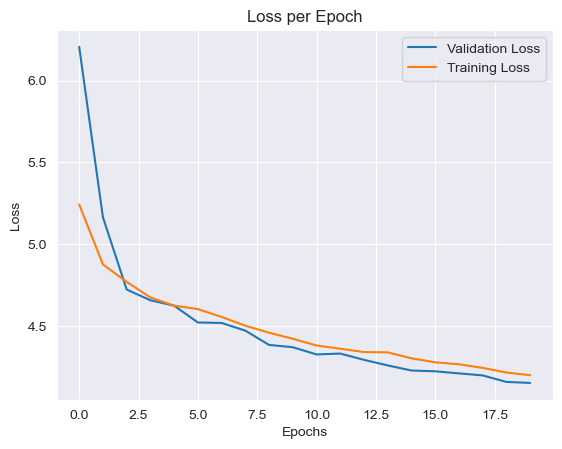

In [38]:
import matplotlib.pyplot as plt

# Plot validation loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Function to plot history of training

In [39]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to create Confusion Matrix¶

In [40]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Display model performance

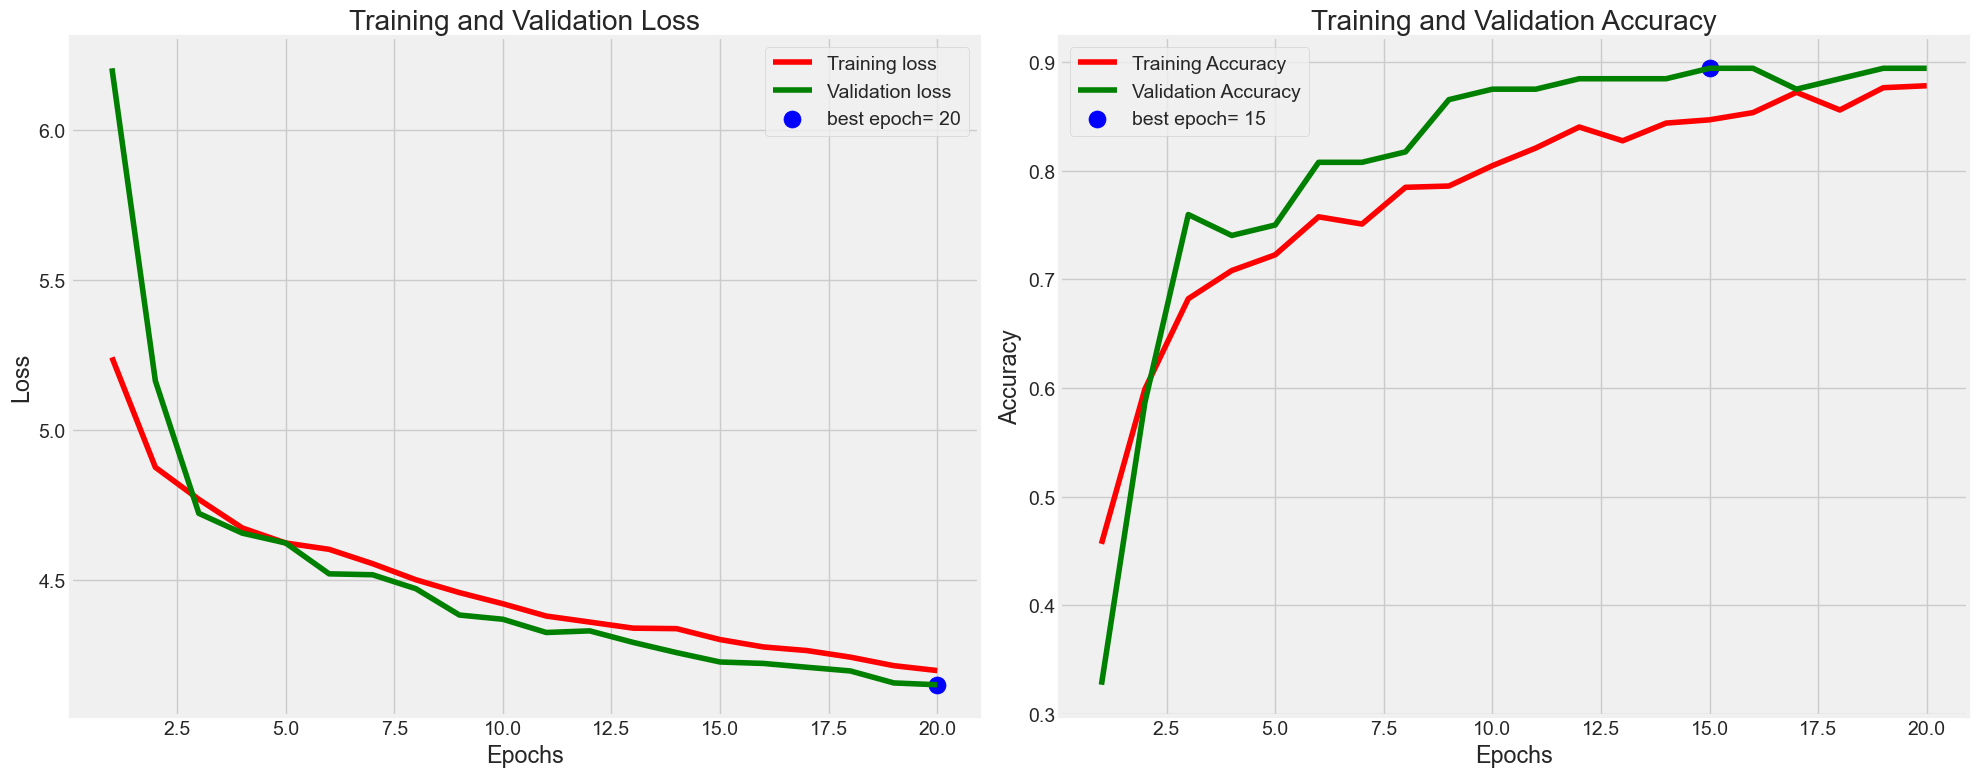

In [41]:
plot_training(history)

# Evaluate model

In [42]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = final_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = final_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = final_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

311/311 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.2987 - auc: 0.4693 - loss: 18.2668 - precision: 0.2987 - recall: 0.2987 
311/311 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.2888 - auc: 0.4646 - loss: 19.9086 - precision: 0.2888 - recall: 0.2888
311/311 ━━━━━━━━━━━━━━━━━━━━ 127s 407ms/step - accuracy: 0.2357 - auc: 0.4208 - loss: 19.6168 - precision: 0.2357 - recall: 0.2357
Train Loss:  18.311431884765625
Train Accuracy:  0.2967430651187897
--------------------
Validation Loss:  19.916872024536133
Validation Accuracy:  0.2884615361690521
--------------------
Test Loss:  19.50913429260254
Test Accuracy:  0.2636655867099762


# Get Predictions

In [43]:
preds = final_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


311/311 ━━━━━━━━━━━━━━━━━━━━ 151s 471ms/step
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2]


# Confusion Matrics and Classification Report

Confusion Matrix, Without Normalization
[[  0   0  18]
 [  8   3 197]
 [  4   2  79]]
                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        18
Malignant cases       0.60      0.01      0.03       208
   Normal cases       0.27      0.93      0.42        85

       accuracy                           0.26       311
      macro avg       0.29      0.31      0.15       311
   weighted avg       0.47      0.26      0.13       311



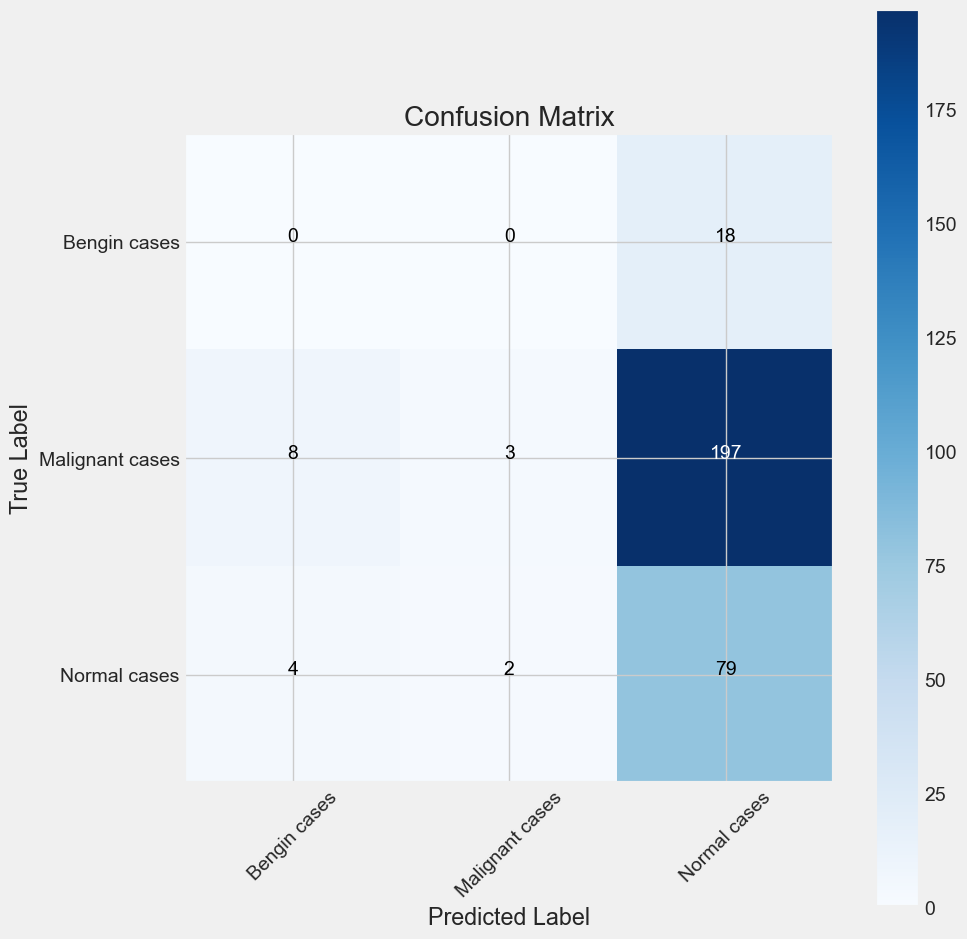

In [44]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

# Save model

In [45]:
import os

# Extract the model's input name
model_name = final_model.input.name.split(":")[0]  # Extract the input name before ":"

# Get user input for the project subject
subject = input('Enter Project Subject: ')

# Calculate accuracy percentage
acc = test_score[1] * 100

# Set the save path
save_path = "MINI PROJECT(lung model)"

# Save the model in the recommended .keras format
save_id = f'{model_name}-{subject}-{"%.2f" % acc}.keras'
model_save_loc = os.path.join(save_path, save_id)
final_model.save(model_save_loc)
print(f'Model was saved as {model_save_loc}')

# Ensure weights filename ends with `.weights.h5` as required by Keras API
weight_save_id = f'{model_name}-{subject}-weights.weights.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)

# Save the model weights in the correct format
final_model.save_weights(weights_save_loc)
print(f'Weights were saved as {weights_save_loc}')


Enter Project Subject:  y


Model was saved as MINI PROJECT(lung model)\keras_tensor_369-y-26.37.keras
Weights were saved as MINI PROJECT(lung model)\keras_tensor_369-y-weights.weights.h5


# Generate CSV files containing classes indicies & image size

In [46]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as MINI PROJECT(lung model)\y-class_dict.csv


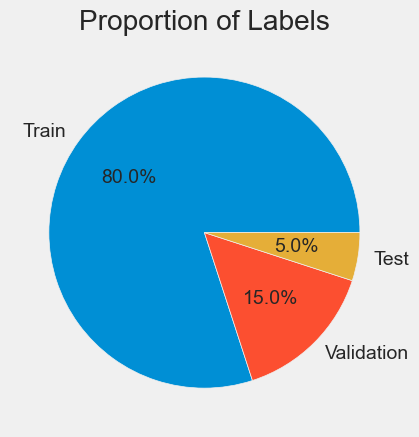

In [47]:
import matplotlib.pyplot as plt

# Sample data
category_dir= ["Train", "Validation", "Test"]
sizes = [ 11855,2223,741 ] 

# Create a pie chart
plt.pie(sizes,labels=category_dir, autopct='%1.1f%%')
plt.title("Proportion of Labels")
plt.show()

In [48]:
from tensorflow.keras.models import load_model

# Load the model without compiling (ignores the optimizer state)
model_path = "MINI PROJECT(lung model)/keras_tensor_369-y-69.45.keras"
model = load_model(model_path, compile=False)

# Now you can use the model for inference/predictions without any issues
# Example: model.predict(data)


In [49]:
def create_model_data(train_df, valid_df, test_df, batch_size):
    ''' This function takes train, validation, and test dataframes and fits them into image data generators,
        because the model takes data from the image data generator. Image data generator converts images into tensors. '''

    # Define model parameters
    img_size = (224, 224)
    channels = 3  # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended: use a custom function for test data batch size, else we can use the normal batch size.
    if test_df is not None:
        ts_length = len(test_df)
        test_batch_size = max(
            sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
        test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just takes the image and returns it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                           class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                           class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size)

    test_gen = None  # Set test_gen to None since it's not used in k_fold_cv

    return train_gen, valid_gen, test_gen

In [50]:
def k_fold_cv(model, train_df, valid_df, batch_size, callbacks, class_weights, n_splits=5, epochs=50):
    fold_acc = []
    fold_loss = []
    fold_reports = []
    fold_cm = np.zeros((3, 3))  # Initialize aggregate confusion matrix
    
    for i in range(n_splits):
        print(f"Fold {i+1}:")
        train_gen, valid_gen, _ = create_model_data(train_df, valid_df, None, batch_size)  # Updated line
        
        # Train the model
        history = model.fit(
            x=train_gen,
            epochs=epochs,
            verbose=0,
            callbacks=callbacks,
            validation_data=valid_gen,
            validation_steps=None,
            shuffle=True,
            class_weight=class_weights
        )
        
        # Evaluate the model
        loss, accuracy = model.evaluate(valid_gen, verbose=0)
        fold_acc.append(accuracy)
        fold_loss.append(loss)
        
        # Predictions and metrics
        y_val = valid_gen.labels
        y_pred = np.argmax(model.predict(valid_gen), axis=1)
        report = classification_report(y_val, y_pred)
        fold_reports.append(report)
        
        cm = confusion_matrix(y_val, y_pred)
        fold_cm += cm

        print(f"Validation Accuracy: {accuracy}")
        print(report)
        print("Confusion Matrix:")
        print(cm)
        print("=" * 50)
    
    # Calculate average metrics
    avg_acc = np.mean(fold_acc)
    avg_loss = np.mean(fold_loss)
    avg_report = classification_report(y_val, y_pred)
    avg_cm = fold_cm / n_splits

    print(f"Average Accuracy: {avg_acc}")
    print(f"Average Loss: {avg_loss}")
    print("Average Classification Report:")
    print(avg_report)
    print("Average Confusion Matrix:")
    print(avg_cm)

    # Plot combined accuracy and loss graphs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, n_splits + 1), fold_acc, marker='o', label='Accuracy')
    plt.title('Fold-wise Validation Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, n_splits + 1), fold_loss, marker='o', label='Loss')
    plt.title('Fold-wise Validation Loss')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return avg_acc, avg_loss, avg_report, avg_cm

In [51]:
# Perform 5-fold cross-validation
avg_acc, avg_loss, avg_report, avg_cm = k_fold_cv(model, train_df, valid_df, batch_size, callbacks, class_weights, epochs=50)

Fold 1:
Found 1658 validated image filenames belonging to 3 classes.
Found 104 validated image filenames belonging to 3 classes.


ValueError: You must call `compile()` before using the model.